In [7]:
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from finta import TA
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import yahoo_finance as yfi
sns.set(rc={'figure.figsize':(11.7,8.27)})

class stock():
    
    """"The name_methods_show() only show the indicator  they related to, 
    between start and end, whereas the name_methods() output a dataframe 
    containing the values on the entire dataset"""
    
    def __init__(self,name):
        self.stock_df_chart = pd.DataFrame(yf.Ticker(name).history(period="max"))
        self.stock_df_chart.columns = map(str.lower, self.stock_df_chart.columns)
        self.name = name
        
    def Bollinger_bands_show(self,start,end, width = False , upper = True, lower = True):
        #La courbe représentant le cours de l'action suit une moyenne mobile à 7 jours(choix arbitraire)
        self.stock_df_chart_chart.columns = map(str.lower, self.stock_df_chart_chart.columns)
        bbands = TA.BBANDS(self.stock_df_chart_chart)
        sns.set()
        if upper :
            bbands[start:end].BB_UPPER.plot()
        if lower :
            bbands[start:end].BB_LOWER.plot()
        

        self.stock_df_chart["open"][start:end].rolling(window=7, center =True).mean().plot(label="MA 7 jours",ls = ":")
        plt.show()
        if width :
            width = TA.BBWIDTH(self.stock_df_chart)
            width[start:end].plot(label="Width", lw =3)
            plt.show()
        
    def cours_show(self):
        #Affiche le cours de l'action

        fig = go.Figure(data=go.Ohlc(x=self.stock_df_chart.index,
            open=self.stock_df_chart['open'],
            high=self.stock_df_chart['high'],
            low=self.stock_df_chart['low'],
            close=self.stock_df_chart['close']))
        fig.show()
        
    def EMA_show(self,start,end):
        #Exponential Moving Average
        TA.EMA(self.stock_df_chart)[start:end].plot()
        plt.show()
        
    def RSI_show(self,start,end):
        #Relative Strengh Indicator
        TA.RSI(self.stock_df_chart)[start:end].plot()
        plt.show()
        
    def ROC_show(self,start,end):
        #Rate of Change
        TA.ROC(self.stock_df_chart)[start:end].plot()
        plt.show()
        
    def BASP_show(self,start,end):
        #Rate of Change
        TA.BASP(self.stock_df_chart)[start:end].plot()
        plt.show()
        
    def MOM_show(self,start,end):
        #Rate of Change
        TA.ROC(self.stock_df_chart)[start:end]

        return()
    
    def EMA(self):
        #Exponential Moving Average
        return TA.EMA(self.stock_df_chart)
        
    def RSI(self):
        #Relative Strengh Indicator
        return TA.RSI(self.stock_df_chart)
        
    def ROC(self):
        #Rate of Change
        return TA.ROC(self.stock_df_chart)
        
    def MOM(self):
        #Momentum
        return TA.MOM(self.stock_df_chart)
    
    def Bollinger_bands(self):
        return TA.BBANDS(self.stock_df_chart)
    
    def Bollinger_width(self):
        return TA.BBWIDTH(self.stock_df_chart)
    
    def price(self, var="open"):
        return(self.stock_df_chart[var])
    
    def BASP(self):
        return TA.BASP(self.stock_df_chart)
    
     
        
        
        
        

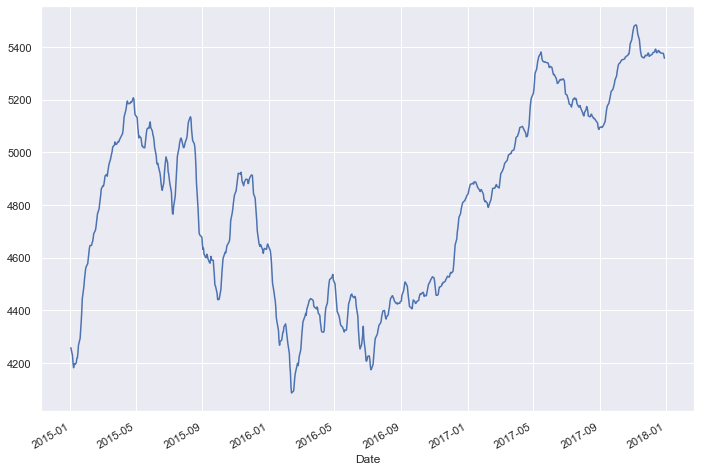

In [8]:
cac40 = stock(name="^FCHI")
cac40.EMA_show("2015","2017")

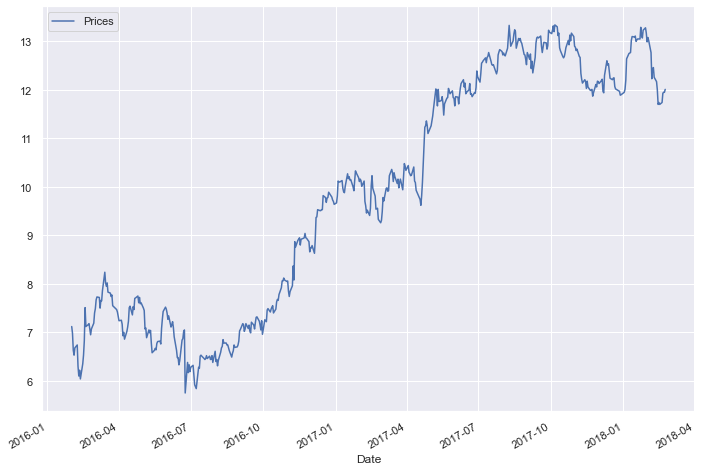

In [9]:
#Création du dataset pour créer le model :
stock_ds = stock(name="ACA.PA")

#Résultats plutôt bons pour le crédit Agricole : ACA.PA, pour APPLE : AAPL, étranges pour MSFT, moyens pour AMZN



""""The only indicators taken into account are, for now : 
Relative Strenght Indicator, 
Momentum of Market, 
Bollinger Bands width, 
Rate of Change, 
Prices (not of the forcasted period of course)"""

X = pd.DataFrame({"RSI" : stock_ds.RSI(), 
                  "MOM" : stock_ds.MOM(), 
                  "Bollinger Width" : stock_ds.Bollinger_width(), 
                  "ROC" : stock_ds.ROC(),
                 "Prices" : stock_ds.price()})

y = pd.DataFrame({"Prices" : stock_ds.price()})

X,y = X.dropna(), y.dropna()

""""The segmentation of the train/test datasets are arbitrary. 
The forecasting period is expected to be Month+1
We expect to encounter some size issues as markets are not open 365/365 days 
and the closing days are not excatly the same every year"""

X_train = X["2014-01":"2016-01"]
y_train = y["2016-02":"2018-02-25"]

X_test = X["2019-01-03":"2019-08"]
y_test = y["2019-02":"2019-09"]

y_train.plot()
plt.show()


/Users/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


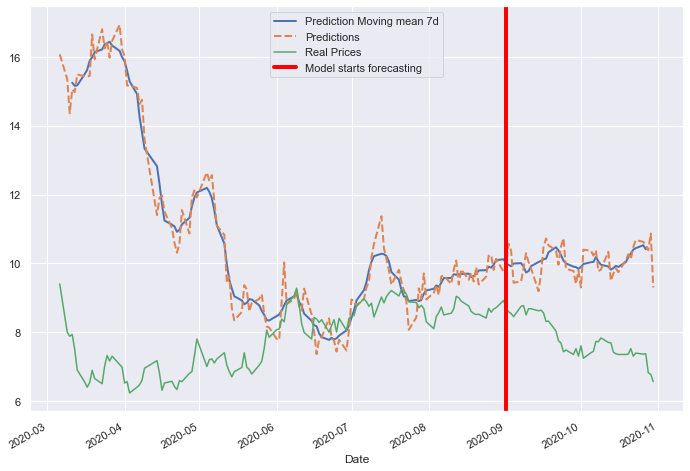

In [10]:


X_end = "2020-09"

X_test = X["2020-02":X_end]
y_test = y["2020-03-06":"2020-10"]

"""" Below stands a way of dealing with the size issue of training datasets.
It's a degree 0 way of dealing with it. There are certainly more efficient 
ways to handle it"""

if len(y_train)-len(X_train)>0 : y_train= y_train[:-abs(len(y_train)-len(X_train))]
if len(y_train)-len(X_train)<0 : X_train= X_train[:-abs(len(y_train)-len(X_train))]
    

    
"""" The ML model chosen is SVR because of the architecture of the output.
Chosing a linear Kernel is arbitrary, could be improved"""

from sklearn.svm import SVR

model = SVR(kernel="linear")
model.fit(X_train, np.ravel(y_train))
y_pred = model.predict(X_test)

"""" Same situation, we have to equalize the size of the test datasets"""

if len(y_test)-len(y_pred)>0 : 
    y_test= y_test[:-abs(len(y_test)-len(y_pred))]
    if len(y_test)-len(y_pred)!=0 : raise ValueError("L'ajustement ne fonctionne pas, y_test est trop long")
if len(y_test)-len(y_pred)<0 : 
    y_pred= y_pred[:-abs(len(y_test)-len(y_pred))]
    if len(y_test)-len(y_pred)!=0 : raise ValueError("L'ajustement ne fonctionne pas, y_pred est trop long")

    
    
"""" Plotting the real prices and the predictions to have a visual assession of 
the quality of our model"""

y_test["Predictions"] = y_pred
y_test["Pred_mean"] = y_test["Predictions"].rolling(window=7, center =True).mean().plot(label="Prediction Moving mean 7d",lw = 2)
y_test["Predictions"].plot(label = "Predictions", ls = "--", lw = 2)
y_test["Prices"].plot(label="Real Prices")

plt.axvline(label = "Model starts forecasting" , x=X_end, ymin=0, ymax=190, lw = 4, color = "red")
plt.legend()
plt.show()



In [11]:
amzn = yf.Ticker("AMZN")
amzn.info

{'zip': '98109-5210',
 'sector': 'Consumer Cyclical',
 'fullTimeEmployees': 1298000,
 'longBusinessSummary': 'Amazon.com, Inc. engages in the retail sale of consumer products and subscriptions in North America and internationally. The company operates through three segments: North America, International, and Amazon Web Services (AWS). It sells merchandise and content purchased for resale from third-party sellers through physical and online stores. The company also manufactures and sells electronic devices, including Kindle, Fire tablets, Fire TVs, Rings, and Echo and other devices; provides Kindle Direct Publishing, an online service that allows independent authors and publishers to make their books available in the Kindle Store; and develops and produces media content. In addition, it offers programs that enable sellers to sell their products on its websites, as well as its stores; and programs that allow authors, musicians, filmmakers, skill and app developers, and others to publish 

In [18]:
from finpie import Fundamentals

fd = Fundamentals('AAPL', freq = 'q')
fd.ratios()

,current_ratio,longterm_debt_to_capital,debt_to_equity_ratio,gross_margin,operating_margin,ebit_margin,ebitda_margin,pretax_profit_margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe__return_on_equity,return_on_tangible_equity,roa__return_on_assets,roi__return_on_investment,book_value_per_share,operating_cash_flow_per_share,free_cash_flow_per_share
date,,,,,,,,,,,,,,,,,,,,
2005-03-31,2.6871,NaN,NaN,29.8489,12.3959,12.3959,NaN,13.4135,8.9423,0.3207,13.8720,3.6520,24.6439,4.5412,4.6230,2.8682,4.5412,0.2771,0.0546,0.0504
2005-06-30,3.0022,NaN,NaN,29.6591,12.1023,12.1023,NaN,13.4091,9.0625,0.3356,12.8290,4.2563,21.1449,4.6767,4.7527,3.0416,4.6767,0.2942,0.0194,0.0168
2005-09-30,2.9538,NaN,NaN,28.1131,11.2017,11.2017,NaN,12.8331,11.5280,0.3194,16.0242,4.1095,21.9005,5.7081,5.7829,3.6818,5.7081,0.3177,0.0317,0.0276
2005-12-31,2.4036,NaN,NaN,27.2047,13.0458,13.0458,NaN,14.4547,9.8278,0.4054,17.1516,4.3193,20.8367,6.7422,6.8179,3.9842,6.7422,0.3539,0.0116,0.0082
2006-03-31,2.5328,NaN,NaN,29.7545,12.1358,12.1358,NaN,13.8793,9.4058,0.3133,15.0098,5.0627,17.7770,4.7224,4.7830,2.9473,4.7224,0.3651,0.0052,0.0130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,1.5978,0.5097,1.2095,38.3548,27.8472,27.8472,NaN,28.2273,24.2172,0.2696,13.8155,2.2986,39.1546,24.8361,24.8361,6.5281,12.1768,5.1044,1.7126,1.5944
2020-03-31,1.4960,0.5318,1.3963,38.3619,22.0414,22.0414,NaN,22.5250,19.2907,0.1820,10.7807,1.9009,47.3467,14.3436,14.3436,3.5109,6.7154,4.5343,0.7749,0.6684
2020-06-30,1.4695,0.5654,1.5595,37.9995,21.9335,21.9335,NaN,22.0106,18.8540,0.1881,9.3024,1.8608,48.3664,15.5682,15.5682,3.5460,6.7655,4.2182,0.9626,0.8701
